In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import keras

import sys
# sys.path.append("/Users/Work/Developer/interpretDL/interprettensor")
root_logdir = "./tf_logs"

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

    
def get1hot(y_train,y_test):
    from sklearn.preprocessing import OneHotEncoder

    enc = OneHotEncoder(categories="auto", sparse=False)
    y_train_1hot = enc.fit_transform([[label] for label in y_train]) # Since the function expects an array of "features" per sample
    y_test_1hot = enc.fit_transform([[label] for label in y_test])

    return y_train_1hot, y_test_1hot
    
tf.__version__

Using TensorFlow backend.


'1.12.0'

### Getting data from csv

In [2]:
filename = "cleaned_ADNI.csv"
raw_data = pd.read_csv(filename)
print(raw_data.info())
raw_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143 entries, 0 to 142
Columns: 299 entries, PTID to DX_bl
dtypes: float64(148), int64(148), object(3)
memory usage: 334.1+ KB
None


,PTID,scandate,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,...,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh,DX_bl
0,094_S_2216,2011-05-04 08:35:04.461,936,1.984,1158,2.107,993,2.306,1226,2.359,...,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579,EMCI
1,029_S_2376,2011-07-05 18:17:58.518,855,2.160,1291,2.287,1137,1.961,1451,2.059,...,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642,EMCI
2,098_S_4003,2016-05-04 15:44:47.525,849,2.122,909,2.272,788,2.430,717,2.606,...,2.222,626,1.870,784,1.826,3182,2.056,195,2.179,CN
3,021_S_2077,2014-10-21 15:26:50.834,762,2.237,969,2.141,1153,2.130,1156,2.135,...,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826,EMCI
4,021_S_5099,2013-06-11 14:47:47.885,752,2.073,960,2.521,873,2.374,810,2.481,...,3.412,790,2.276,665,2.535,2914,2.168,183,2.166,EMCI


**Should do some form of test train split**

We'll start with a (stratified) shuffle split for now. Startified sampling ensures that **test** set has the correct representation of each category.

Later move on to K-Folds to really test out the network...

# IDEAS

## How about make it CN vs AD only


### How about we fuse some of the classes - wont reduce samples
> NC = NC + SMC -> just fuse them 

> MCI = EMCI + LMCI

> AD

### Try removing SA from the features
> Just keep Thickness

#### Add hippocampus volumes L and R
> from aseg.stat

> Also add up all volumes in aseg.stat and add up to get ICV intra cranial volume

### Instead could normalize the thickness by ICV (divide them by ICV value)
> Note that ICV = mm^3 and thickness = mm, so divide by ICV^(1/3)


### > Balancing the training set -> SMOTE
- look at scikit learn, scipy
- just do it in feature space
- will interpolate samples to balance the classes


### ANOTHER approach is to ** pretrain ** if nothing else works
- Pretrain on all 600 samples
- Freeze all but the last two layers and retrain on 143 dataset
- Make sure that test set is never seen, eevn in pretraining

In [18]:
label_col = "DX_bl"
features = raw_data.drop(columns=["PTID", "scandate",label_col])
raw_labels = raw_data[label_col].copy()
features.head()

,G_and_S_frontomargin_SA_lh,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_SA_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_SA_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_SA_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_SA_lh,G_and_S_transv_frontopol_TH_lh,...,S_suborbital_SA_rh,S_suborbital_TH_rh,S_subparietal_SA_rh,S_subparietal_TH_rh,S_temporal_inf_SA_rh,S_temporal_inf_TH_rh,S_temporal_sup_SA_rh,S_temporal_sup_TH_rh,S_temporal_transverse_SA_rh,S_temporal_transverse_TH_rh
0,936,1.984,1158,2.107,993,2.306,1226,2.359,443,2.338,...,254,1.421,1007,1.937,763,1.759,4349,2.025,249,1.579
1,855,2.160,1291,2.287,1137,1.961,1451,2.059,685,2.207,...,309,2.457,1195,1.804,635,1.970,4895,2.071,344,1.642
2,849,2.122,909,2.272,788,2.430,717,2.606,474,2.456,...,250,2.222,626,1.870,784,1.826,3182,2.056,195,2.179
3,762,2.237,969,2.141,1153,2.130,1156,2.135,421,2.282,...,180,2.880,1127,2.245,789,1.924,4399,2.014,243,1.826
4,752,2.073,960,2.521,873,2.374,810,2.481,460,2.331,...,197,3.412,790,2.276,665,2.535,2914,2.168,183,2.166


In [23]:
# Getting all the columns related to surface area
thickness_features = [x for x in features.columns if "SA" in x ]

# Removing SA to reduce feature dimensions
raw_features = features.drop(columns=thickness_features)

raw_features.head()

,G_and_S_frontomargin_TH_lh,G_and_S_occipital_inf_TH_lh,G_and_S_paracentral_TH_lh,G_and_S_subcentral_TH_lh,G_and_S_transv_frontopol_TH_lh,G_and_S_cingul-Ant_TH_lh,G_and_S_cingul-Mid-Ant_TH_lh,G_and_S_cingul-Mid-Post_TH_lh,G_cingul-Post-dorsal_TH_lh,G_cingul-Post-ventral_TH_lh,...,S_parieto_occipital_TH_rh,S_pericallosal_TH_rh,S_postcentral_TH_rh,S_precentral-inf-part_TH_rh,S_precentral-sup-part_TH_rh,S_suborbital_TH_rh,S_subparietal_TH_rh,S_temporal_inf_TH_rh,S_temporal_sup_TH_rh,S_temporal_transverse_TH_rh
0,1.984,2.107,2.306,2.359,2.338,2.185,2.351,2.294,2.656,2.034,...,1.836,2.148,1.731,2.309,1.984,1.421,1.937,1.759,2.025,1.579
1,2.160,2.287,1.961,2.059,2.207,2.371,2.121,1.987,2.289,2.060,...,1.692,1.832,1.589,2.189,1.861,2.457,1.804,1.970,2.071,1.642
2,2.122,2.272,2.430,2.606,2.456,2.541,2.580,2.276,2.578,2.291,...,1.977,2.623,1.882,2.192,2.071,2.222,1.870,1.826,2.056,2.179
3,2.237,2.141,2.130,2.135,2.282,2.218,2.213,2.332,2.985,2.224,...,1.749,2.065,1.882,2.071,2.104,2.880,2.245,1.924,2.014,1.826
4,2.073,2.521,2.374,2.481,2.331,2.854,2.854,2.533,3.032,2.412,...,2.118,2.887,1.862,2.146,2.238,3.412,2.276,2.535,2.168,2.166


In [24]:
raw_labels.value_counts()/len(raw_labels)

EMCI    0.321678
CN      0.209790
AD      0.181818
LMCI    0.146853
SMC     0.139860
Name: DX_bl, dtype: float64

## Fusing all the columns

In [88]:
# Mapping to convert labels
fuse_maps = {"SMC": "CN", "EMCI":"MCI", "LMCI":"MCI"}

# Lambda fucntion to be used with Map func
fuse = lambda x: fuse_maps[x] if x in fuse_maps else x
dist = lambda x: pd.Series(x).value_counts()/len(x)

fused_labels = list(map(fuse, raw_labels))

In [89]:
print("Sample Size:", len(fused_labels))
dist(fused_labels)

Sample Size: 143


MCI    0.468531
CN     0.349650
AD     0.181818
dtype: float64

## Using SMOTE

> Generates interpolated samples to balance training data 

In [90]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state=42)

features, labels = sm.fit_resample(raw_features, fused_labels)

print(features.shape)
print(pd.Series(labels).value_counts()/len(labels))
len(labels)

(201, 148)
MCI    0.333333
CN     0.333333
AD     0.333333
dtype: float64


201

### Get 1 Hot Vector representation of the *fused* categorical labels

In [115]:
# Converting labels to 1-Hot Vectors
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(categories="auto", sparse=False)
labels_1hot = enc.fit_transform([[label] for label in labels]) # Since the function expects an array of "features" per sample

print("Categories:", enc.categories_)

print(y[:5])
labels_1hot[:5]
print(len(labels))

Categories: [array(['AD', 'CN', 'MCI'], dtype=object)]
['MCI' 'MCI' 'CN' 'MCI' 'MCI']
201


# Normalizing training inputs

Does not work at all without normalization. The ranges for surface area and thickness are vastly different.

In [116]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler() #x-u/sd
features = scaler.fit_transform(features) # Note that features is no longer a dataframe

In [117]:
from sklearn.model_selection import StratifiedShuffleSplit

# The train set will have equal amounts of each target class
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(features, labels):
    X_train = features[train_index]
    y_train_1hot = labels_1hot[train_index]
    X_test = features[test_index]
    y_test_1hot = labels_1hot[test_index]

In [118]:
print("Train Size:", X_train.shape)
# print(y_test_1hot)

Train Size: (160, 148)


### Building the network

We will build a fully connected (slightly) deep network with no drop outs or batch normalization for now

In [119]:
from keras import optimizers
from keras import regularizers

def build_dnn(num_features):
    keras.backend.clear_session()
    reset_graph()
    
    reg_scale = 0.001 # For L1 Reg
    my_reg = regularizers.l1_l2(reg_scale) # Can change this if needed
    
    dnn = keras.models.Sequential()

    Dense = keras.layers.Dense

    # Using He initialization
    he_init = tf.contrib.layers.variance_scaling_initializer()
    

    dnn.add(Dense(units = 300, activation="elu", input_dim=num_features,
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units = 150, activation="elu",
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.5))
    dnn.add(Dense(units=50, activation='elu',
                  kernel_initializer=he_init, kernel_regularizer = my_reg))
    dnn.add(keras.layers.Dropout(0.1))
    
    dnn.add(Dense(units=3, activation="softmax", kernel_initializer=he_init)) # 5 labels -> logits for now

    dnn.compile(loss='categorical_crossentropy',
                  optimizer="adam",
                  metrics=['accuracy'])
    
    return dnn

dnn = build_dnn(X_train.shape[1])
dnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 300)               44700     
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 150)               45150     
_________________________________________________________________
dropout_2 (Dropout)          (None, 150)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 50)                7550      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 3)                 153       
Total para

In [120]:
dnn = build_dnn(X_train.shape[1])
history = dnn.fit(X_train, y_train_1hot, epochs=100, batch_size = 20, validation_data=(X_test, y_test_1hot))

Train on 160 samples, validate on 41 samples
Epoch 1/100
160/160 [==============================] - 0s 3ms/step - loss: 20.4187 - acc: 0.4437 - val_loss: 19.3090 - val_acc: 0.4878
Epoch 2/100
160/160 [==============================] - 0s 132us/step - loss: 19.4878 - acc: 0.5312 - val_loss: 18.9162 - val_acc: 0.4634
Epoch 3/100
160/160 [==============================] - 0s 142us/step - loss: 18.9205 - acc: 0.5563 - val_loss: 18.7041 - val_acc: 0.5122
Epoch 4/100
160/160 [==============================] - 0s 139us/step - loss: 18.5833 - acc: 0.6063 - val_loss: 18.5293 - val_acc: 0.5122
Epoch 5/100
160/160 [==============================] - 0s 146us/step - loss: 18.0967 - acc: 0.6437 - val_loss: 18.2687 - val_acc: 0.5854
Epoch 6/100
160/160 [==============================] - 0s 148us/step - loss: 17.8173 - acc: 0.6500 - val_loss: 18.0362 - val_acc: 0.6341
Epoch 7/100
160/160 [==============================] - 0s 157us/step - loss: 17.2437 - acc: 0.7687 - val_loss: 17.7643 - val_acc: 0.609

0.7560975667906971


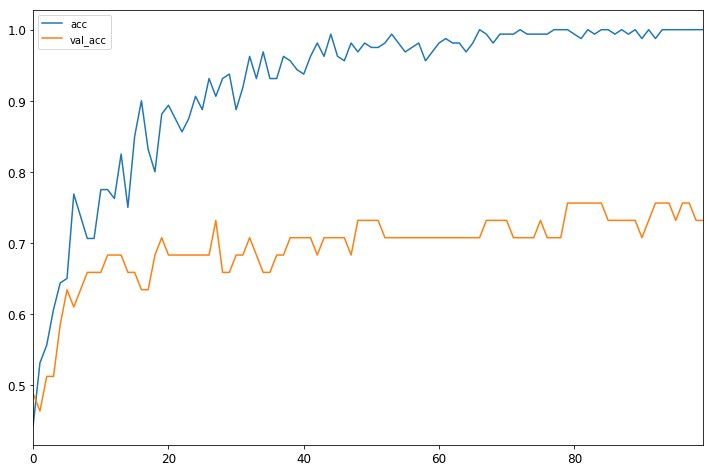

In [123]:
df = pd.DataFrame(history.history)
print(max(df["val_acc"]))
df[["acc","val_acc"]].plot(figsize=(12,8))

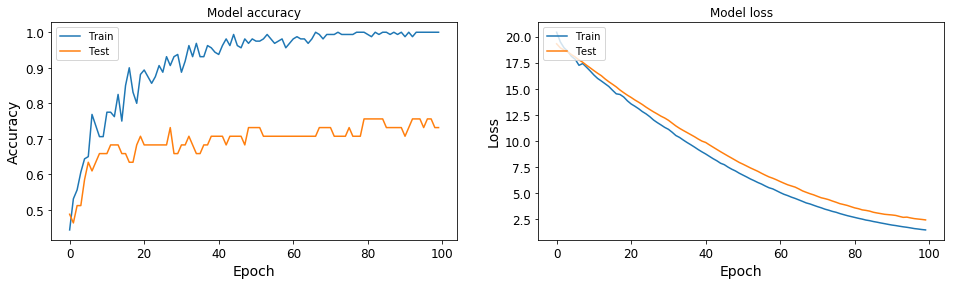

In [124]:
def plot_history(history):
    fig, axs = plt.subplots(1, 2, figsize=(16,4))

    # Plot training & validation accuracy values
    axs[0].plot(history.history['acc'])
    axs[0].plot(history.history['val_acc'])
    axs[0].set(title='Model accuracy', ylabel='Accuracy', xlabel='Epoch')
    axs[0].legend(['Train', 'Test'], loc='upper left')

    # Plot training & validation loss values
    axs[1].plot(history.history['loss'])
    axs[1].plot(history.history['val_loss'])
    axs[1].set(title='Model loss',ylabel='Loss', xlabel='Epoch')
    axs[1].legend(['Train', 'Test'], loc='upper left')
    plt.show()

plot_history(history)

In [96]:
loss_and_metrics = dnn.evaluate(X_test, y_test_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

41/41 [==============================] - 0s 83us/step
Scores on test set: loss=1.418 accuracy=0.7317


In [97]:
loss_and_metrics = dnn.evaluate(features, labels_1hot)
print("Scores on test set: loss={:0.3f} accuracy={:.4f}".format(*loss_and_metrics))

201/201 [==============================] - 0s 36us/step
Scores on test set: loss=4.067 accuracy=0.3433


In [151]:
features.shape

(201, 148)

## Using K=10 Fold Cross Validation

In [128]:
def getKF(X,y, n_splits=10):
    from sklearn.model_selection import KFold
    kf = KFold(n_splits=n_splits) #Default = 10

    for train_index, test_index in kf.split(X):
        X_train = X[train_index]
        y_train = y[train_index]
        X_test = X[test_index]
        y_test = y[test_index]
        
        yield X_train, y_train, X_test, y_test

histories = []
for X_train, y_train_1hot, X_test, y_test_1hot in getKF(features, labels_1hot):
    dnn = build_dnn(X_train.shape[1])
    history = dnn.fit(X_train, y_train_1hot, epochs=50, batch_size = 20, validation_data=(X_test, y_test_1hot))
    histories.append(history)
    print("------"*50)

Train on 180 samples, validate on 21 samples
Epoch 1/50
180/180 [==============================] - 0s 2ms/step - loss: 20.7864 - acc: 0.3889 - val_loss: 19.4995 - val_acc: 0.3333
Epoch 2/50
180/180 [==============================] - 0s 125us/step - loss: 19.6795 - acc: 0.5444 - val_loss: 18.7910 - val_acc: 0.3810
Epoch 3/50
180/180 [==============================] - 0s 133us/step - loss: 18.8908 - acc: 0.5722 - val_loss: 18.2494 - val_acc: 0.5238
Epoch 4/50
180/180 [==============================] - 0s 140us/step - loss: 18.6439 - acc: 0.5944 - val_loss: 17.9440 - val_acc: 0.6667
Epoch 5/50
180/180 [==============================] - 0s 141us/step - loss: 18.1343 - acc: 0.6167 - val_loss: 17.7011 - val_acc: 0.6190
Epoch 6/50
180/180 [==============================] - 0s 138us/step - loss: 17.6964 - acc: 0.6444 - val_loss: 17.5111 - val_acc: 0.5238
Epoch 7/50
180/180 [==============================] - 0s 144us/step - loss: 17.3117 - acc: 0.6944 - val_loss: 17.3131 - val_acc: 0.5238
Epoch

In [129]:
len(histories)

10

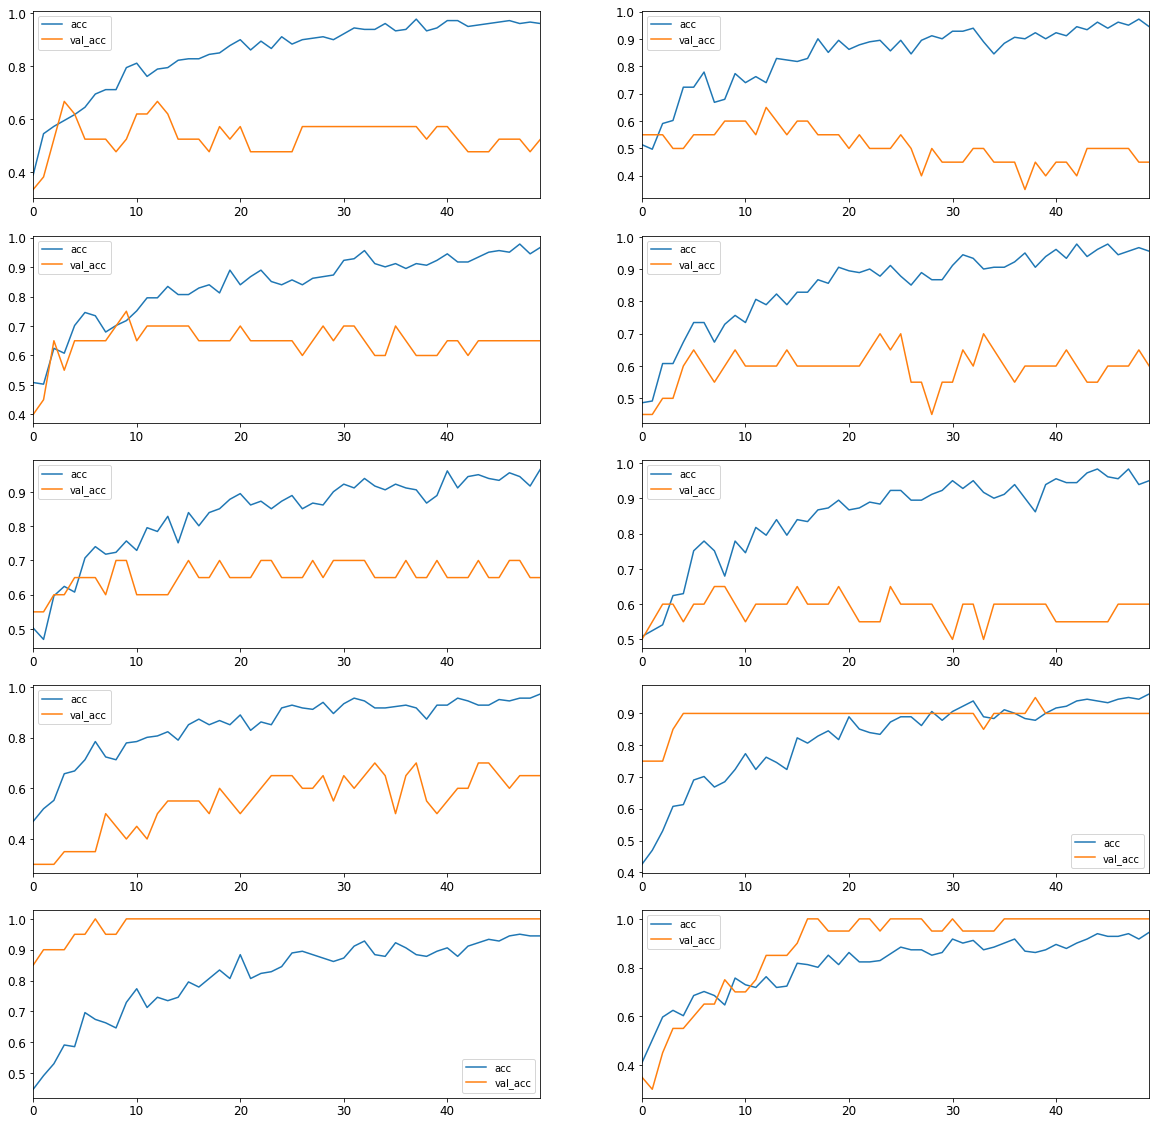

In [148]:
fig, axs = plt.subplots(len(histories)//2,2, figsize=(20,20))
axs=axs.flatten()
for i,history in enumerate(histories):
    df = pd.DataFrame(history.history)
    df[["acc","val_acc"]].plot(ax=axs[i])

In [150]:
df

,val_loss,val_acc,loss,acc
0,19.082294,0.35,20.834457,0.408840
1,19.109783,0.30,19.450632,0.502762
2,18.751400,0.45,18.795289,0.596685
3,18.066191,0.55,18.677598,0.624309
4,17.686468,0.55,18.217976,0.602210
5,17.361328,0.60,17.737867,0.685083
6,16.986967,0.65,17.251514,0.701657
7,16.673126,0.65,17.109010,0.685083
8,16.403835,0.75,16.878295,0.646409
9,16.170507,0.70,16.503896,0.756906


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14686a390>,
      dtype=object)